In [1]:
# print all output from a single cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [2]:
import numpy as np
from dotenv import load_dotenv, find_dotenv
from pathlib import Path
import romancal
import roman_datamodels as rdm
import os
import wcs_footprint_visualizer as wfv

romancal.__version__
rdm.__version__
print(os.getenv('CRDS_CONTEXT'))

%matplotlib inline

load_dotenv(find_dotenv(), override=True)  # take environment variables from .env.

img_path = Path("/Users/mteodoro/ROMAN/SYNTHETIC_IMAGES/IMAGES/23Q4_B11/L2")
img_list = [x for x in img_path.glob("r00005*_cal.asdf")]
img_list.sort()
len(img_list)


'0.10.1.dev203+gd0b1167'

'0.17.1'

roman_0051.pmap


True

29

# Run Romancal Steps

### Fix meta.filename (if necessary)

In [ ]:
for filename in img_list:
    with rdm.open(filename) as dm:
        if not hasattr(dm.meta, "filename") or dm.meta.filename == "None":
            dm.meta["filename"] = filename.name
            dm.save(filename, dir_path=filename.parent)

In [ ]:
# from romancal.pipeline import ExposurePipeline as pipeline
# from romancal.dq_init import DQInitStep
# from romancal.saturation import SaturationStep
# from romancal.linearity import LinearityStep
# from romancal.dark_current import DarkCurrentStep
# from romancal.jump import JumpStep
# from romancal.ramp_fitting import RampFitStep
# from romancal.assign_wcs import AssignWcsStep
# from romancal.source_detection import SourceDetectionStep
from romancal.tweakreg import TweakRegStep

In [3]:
import datetime


def timer(pipeline_step, input, **kwargs):
    tic = datetime.datetime.now()
    res = pipeline_step.call(input, **kwargs)
    toc = datetime.datetime.now()
    dt = toc - tic
    
    print("")
    print(f"##################  {pipeline_step.__name__} finished in {dt}  ##################")
    print("")
    
    return res

In [ ]:
result_list = []
cal_img_list = []
output_filename_suffix = "_proc"

total = len(img_list)

for i, img in enumerate(img_list):
    
    # get file path (result will be saved to this path)
    file_path = img.parent
    # get filename
    filename = img.name
    # result filename
    if filename.count('uncal'):
        output_filename = filename.replace('_uncal', '_cal')
    else:
        output_filename = f"{img.stem}{output_filename_suffix}{img.suffix}"

    
    if not file_path.joinpath("PROC", output_filename).is_file():
        try:
            # execute pipeline steps
            res = img
            # res = timer(DQInitStep, res)
            # res = timer(SaturationStep, res)
            # res = timer(LinearityStep, res)
            # res = timer(DarkCurrentStep, res)
            # # use the keyword arguments below for speed
            # res = timer(JumpStep, res, **{"rejection_threshold": 200., "three_group_rejection_threshold": 200., "four_group_rejection_threshold": 200.})
            # res = timer(RampFitStep, res)
            # res = timer(AssignWcsStep, res)
            # res = timer(SourceDetectionStep, res)
            res = timer(TweakRegStep, [res])
            
            # append result to list
            result_list.append(res)
            # append calibrated filename to list
            cal_img_list.append(file_path.joinpath("PROC", output_filename))

            # save calibrated model using ModelContainer.save()
            res.save(
                dir_path=file_path.joinpath("PROC"),
                **{"output_suffix": output_filename_suffix}
            )
            print(f"STATUS: {100.0 * (i + 1) / total:.2f}% PROCESSED.")
        except BufferError as e:
            print("##########################################")
            print(f"Ooops...!! FAILED PROCESSING {filename}.")
            print("##########################################")
            print(e)
            print(f"STATUS: {100.0 * (i + 1) / total:.2f}% PROCESSED.")
    
print("Stop")

# [rdm.meta.crds_context_used for rdm in result]

# Run Resample Step on PROC files

In [4]:
from romancal.resample import ResampleStep
from romancal.datamodels import ModelContainer

---

### Use case #1: call ResampleStep on a single file
#### Returns: `roman_datamodels.datamodels._datamodels.MosaicModel`

In [5]:
proc_files = img_path.joinpath("PROC").glob("*_proc.asdf")
files_to_proc = sorted(proc_files)
filename = files_to_proc[0].as_posix()
filename
dm = rdm.open(filename)
dm.meta.filename

'/Users/mteodoro/ROMAN/SYNTHETIC_IMAGES/IMAGES/23Q4_B11/L2/PROC/r0000501001001001001_01101_0001_WFI01_cal_proc.asdf'

/Users/mteodoro/.pyenv/versions/3.11.2/envs/romancal_resample_venv_dev/lib/python3.11/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


'r0000501001001001001_01101_0001_WFI01_cal.asdf'

In [6]:
res = timer(ResampleStep, filename)

/Users/mteodoro/.pyenv/versions/3.11.2/envs/romancal_resample_venv_dev/lib/python3.11/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
2023-08-18 16:09:45,809 - CRDS - ERROR -  Error determining best reference for 'pars-resamplestep'  =   Unknown reference type 'pars-resamplestep'
2023-08-18 16:09:45,812 - stpipe.ResampleStep - INFO - ResampleStep instance created.
2023-08-18 16:09:45,907 - stpipe.ResampleStep - INFO - Step ResampleStep running with args ('/Users/mteodoro/ROMAN/SYNTHETIC_IMAGES/IMAGES/23Q4_B11/L2/PROC/r0000501001001001001_01101_0001_WFI01_cal_proc.asdf',).
2023-08-18 16:09:45,909 - stpipe.ResampleStep - INFO - Step ResampleStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.asdf', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': No


##################  ResampleStep finished in 0:01:00.848976  ##################



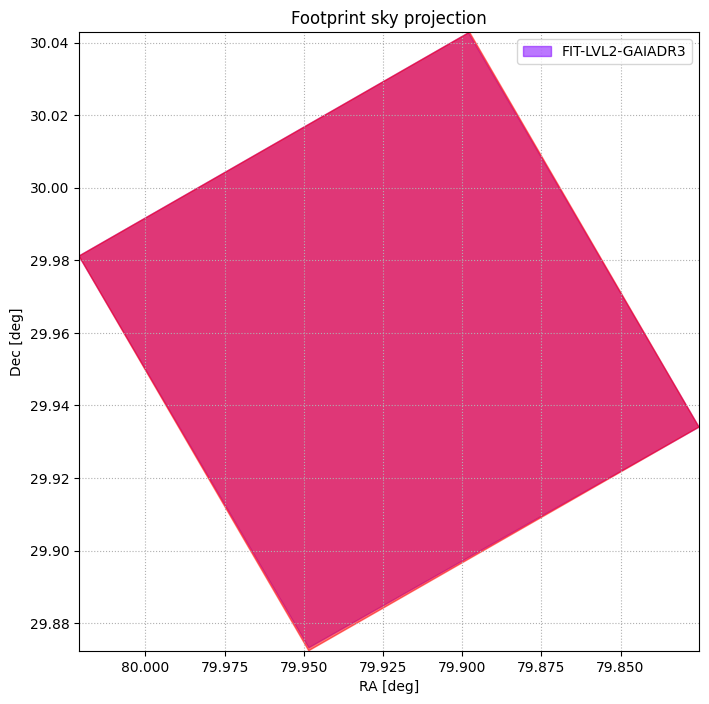

In [7]:
wcs_single = wfv.plot([dm.meta.wcs, res.meta.wcs])

---

### Use case #2: call ResampleStep on a DataModel
#### Returns: list of `roman_datamodels.datamodels._datamodels.MosaicModel`

In [9]:
proc_files = img_path.joinpath("PROC").glob("*_proc.asdf")
files_to_proc = sorted(proc_files)
files_to_proc[0]
dm = rdm.open(files_to_proc[0])
dm.meta.filename

PosixPath('/Users/mteodoro/ROMAN/SYNTHETIC_IMAGES/IMAGES/23Q4_B11/L2/PROC/r0000501001001001001_01101_0001_WFI01_cal_proc.asdf')

'r0000501001001001001_01101_0001_WFI01_cal.asdf'

In [10]:
res = timer(ResampleStep, dm)

/Users/mteodoro/.pyenv/versions/3.11.2/envs/romancal_resample_venv_dev/lib/python3.11/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
2023-08-18 16:11:22,371 - CRDS - ERROR -  Error determining best reference for 'pars-resamplestep'  =   Unknown reference type 'pars-resamplestep'
2023-08-18 16:11:22,374 - stpipe.ResampleStep - INFO - ResampleStep instance created.
2023-08-18 16:11:22,496 - stpipe.ResampleStep - INFO - Step ResampleStep running with args (<roman_datamodels.datamodels._datamodels.ImageModel object at 0x1496b2ed0>,).
2023-08-18 16:11:22,498 - stpipe.ResampleStep - INFO - Step ResampleStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.asdf', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir


##################  ResampleStep finished in 0:00:53.250255  ##################



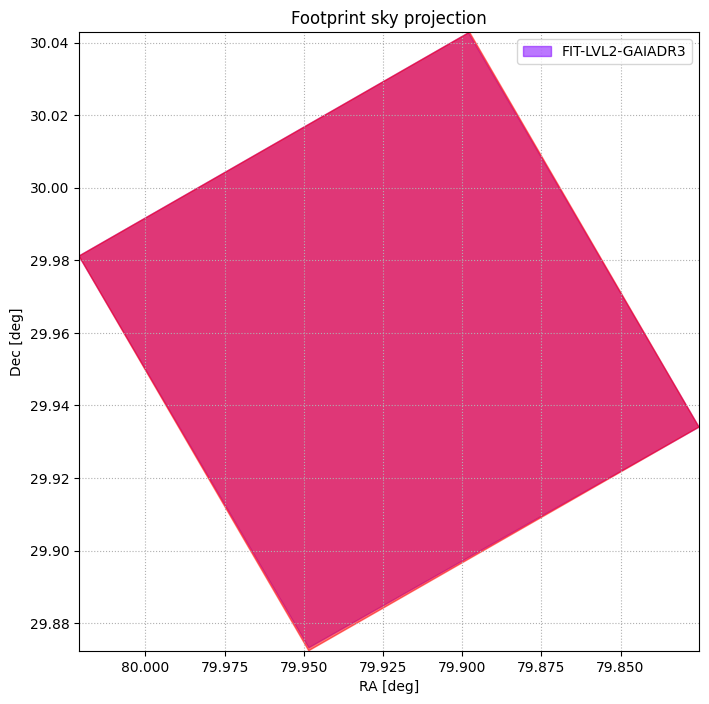

In [11]:
wcs_single = wfv.plot([dm.meta.wcs, res.meta.wcs])

---

### Use case #3: call ResampleStep on an ASN file

#### Returns: `roman_datamodels.datamodels._datamodels.MosaicModel`

- Same SCA from different exposures

In [13]:
proc_files = img_path.joinpath("PROC").glob("*_WFI02_cal_proc.asdf")
files_to_proc = sorted(proc_files)
files_to_proc[:2]
mc = ModelContainer(files_to_proc[:2])

[PosixPath('/Users/mteodoro/ROMAN/SYNTHETIC_IMAGES/IMAGES/23Q4_B11/L2/PROC/r0000501001001001001_01101_0001_WFI02_cal_proc.asdf'),
 PosixPath('/Users/mteodoro/ROMAN/SYNTHETIC_IMAGES/IMAGES/23Q4_B11/L2/PROC/r0000501001001001001_01101_0002_WFI02_cal_proc.asdf')]

In [14]:
asn_file = Path("./IMAGES/23Q4_B11/L2/PROC/resample_same_sca_different_exposures_asn.json").resolve().as_posix()
asn_file

'/Users/mteodoro/ROMAN/SYNTHETIC_IMAGES/IMAGES/23Q4_B11/L2/PROC/resample_same_sca_different_exposures_asn.json'

In [15]:
res_asn = timer(ResampleStep, asn_file)

2023-08-18 16:14:17,472 - stpipe - WARNING - Input dataset is not an instance of AbstractDataModel.
2023-08-18 16:14:17,472 - stpipe - INFO - PARS-RESAMPLESTEP: CRDS parameter reference retrieval disabled.
2023-08-18 16:14:17,474 - stpipe.ResampleStep - INFO - ResampleStep instance created.
2023-08-18 16:14:17,723 - stpipe.ResampleStep - INFO - Step ResampleStep running with args ('/Users/mteodoro/ROMAN/SYNTHETIC_IMAGES/IMAGES/23Q4_B11/L2/PROC/resample_same_sca_different_exposures_asn.json',).
2023-08-18 16:14:17,725 - stpipe.ResampleStep - INFO - Step ResampleStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.asdf', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'output_shape': None, 'crpix': None, 'crval': None, 'rotation': None, 'pixel_scale


##################  ResampleStep finished in 0:01:45.326355  ##################



/Users/mteodoro/.pyenv/versions/3.11.2/envs/romancal_resample_venv_dev/lib/python3.11/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


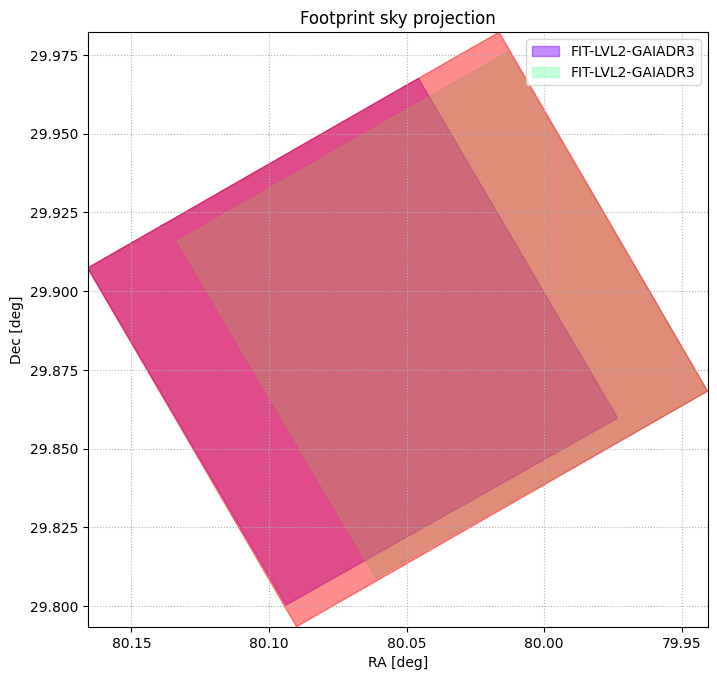

In [16]:
wcs_mosaic = wfv.plot([mc[0].meta.wcs, mc[1].meta.wcs, res_asn.meta.wcs])

- Same exposure different SCAs

In [17]:
proc_files = img_path.joinpath("PROC").glob("*0001_WFI*_cal_proc.asdf")
files_to_proc = sorted(proc_files)
files_to_proc[:2]
mc = ModelContainer(files_to_proc[:2])

'/Users/mteodoro/ROMAN/SYNTHETIC_IMAGES/IMAGES/23Q4_B11/L2/PROC/resample_different_sca_same_exposure_asn.json'

In [18]:
asn_file = Path("./IMAGES/23Q4_B11/L2/PROC/resample_different_sca_same_exposure_asn.json").resolve().as_posix()
asn_file

[PosixPath('/Users/mteodoro/ROMAN/SYNTHETIC_IMAGES/IMAGES/23Q4_B11/L2/PROC/r0000501001001001001_01101_0001_WFI01_cal_proc.asdf'),
 PosixPath('/Users/mteodoro/ROMAN/SYNTHETIC_IMAGES/IMAGES/23Q4_B11/L2/PROC/r0000501001001001001_01101_0001_WFI02_cal_proc.asdf')]

In [19]:
res_asn = timer(ResampleStep, asn_file)

2023-08-18 16:17:44,793 - stpipe - WARNING - Input dataset is not an instance of AbstractDataModel.
2023-08-18 16:17:44,794 - stpipe - INFO - PARS-RESAMPLESTEP: CRDS parameter reference retrieval disabled.
2023-08-18 16:17:44,795 - stpipe.ResampleStep - INFO - ResampleStep instance created.
2023-08-18 16:17:45,023 - stpipe.ResampleStep - INFO - Step ResampleStep running with args ('/Users/mteodoro/ROMAN/SYNTHETIC_IMAGES/IMAGES/23Q4_B11/L2/PROC/resample_different_sca_same_exposure_asn.json',).
2023-08-18 16:17:45,025 - stpipe.ResampleStep - INFO - Step ResampleStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.asdf', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'output_shape': None, 'crpix': None, 'crval': None, 'rotation': None, 'pixel_scale_


##################  ResampleStep finished in 0:01:53.470463  ##################



/Users/mteodoro/.pyenv/versions/3.11.2/envs/romancal_resample_venv_dev/lib/python3.11/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


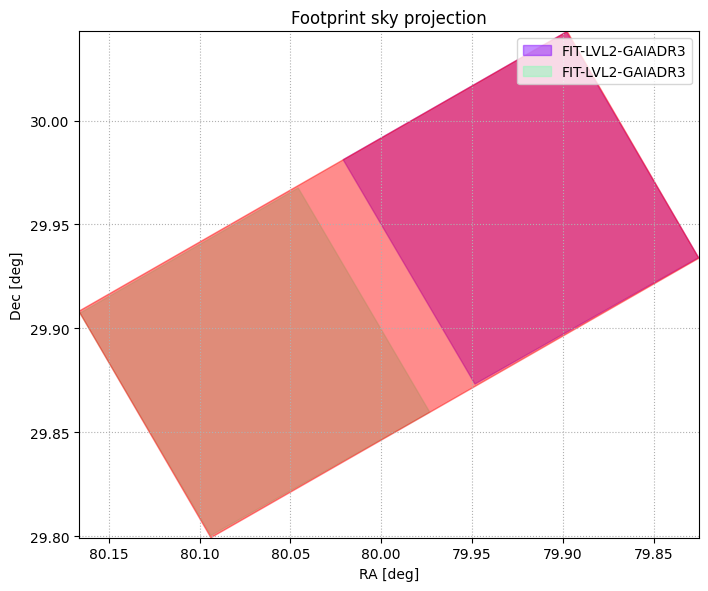

In [20]:
wcs_mosaic = wfv.plot([mc[0].meta.wcs, mc[1].meta.wcs, res_asn.meta.wcs])

---

### Use case #4: call ResampleStep on a ModelContainer

#### Returns: `roman_datamodels.datamodels._datamodels.MosaicModel`

In [35]:
proc_files = img_path.joinpath("PROC").glob("*0001_WFI*_proc.asdf")
files_to_proc = sorted(proc_files)
files_to_proc
mc = ModelContainer(files_to_proc)

[PosixPath('/Users/mteodoro/ROMAN/SYNTHETIC_IMAGES/IMAGES/23Q4_B11/L2/PROC/r0000501001001001001_01101_0001_WFI01_cal_proc.asdf'),
 PosixPath('/Users/mteodoro/ROMAN/SYNTHETIC_IMAGES/IMAGES/23Q4_B11/L2/PROC/r0000501001001001001_01101_0001_WFI02_cal_proc.asdf'),
 PosixPath('/Users/mteodoro/ROMAN/SYNTHETIC_IMAGES/IMAGES/23Q4_B11/L2/PROC/r0000501001001001001_01101_0001_WFI03_cal_proc.asdf'),
 PosixPath('/Users/mteodoro/ROMAN/SYNTHETIC_IMAGES/IMAGES/23Q4_B11/L2/PROC/r0000501001001001001_01101_0001_WFI04_cal_proc.asdf'),
 PosixPath('/Users/mteodoro/ROMAN/SYNTHETIC_IMAGES/IMAGES/23Q4_B11/L2/PROC/r0000501001001001001_01101_0001_WFI05_cal_proc.asdf'),
 PosixPath('/Users/mteodoro/ROMAN/SYNTHETIC_IMAGES/IMAGES/23Q4_B11/L2/PROC/r0000501001001001001_01101_0001_WFI06_cal_proc.asdf'),
 PosixPath('/Users/mteodoro/ROMAN/SYNTHETIC_IMAGES/IMAGES/23Q4_B11/L2/PROC/r0000501001001001001_01101_0001_WFI08_cal_proc.asdf'),
 PosixPath('/Users/mteodoro/ROMAN/SYNTHETIC_IMAGES/IMAGES/23Q4_B11/L2/PROC/r00005010010010

In [36]:
res = timer(ResampleStep, mc)

2023-08-18 16:33:09,935 - stpipe - WARNING - Input dataset is not an instance of AbstractDataModel.
2023-08-18 16:33:09,936 - stpipe - INFO - PARS-RESAMPLESTEP: CRDS parameter reference retrieval disabled.
2023-08-18 16:33:09,938 - stpipe.ResampleStep - INFO - ResampleStep instance created.
2023-08-18 16:33:10,277 - stpipe.ResampleStep - INFO - Step ResampleStep running with args (<romancal.datamodels.container.ModelContainer object at 0x14b5baf10>,).
2023-08-18 16:33:10,279 - stpipe.ResampleStep - INFO - Step ResampleStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.asdf', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'output_shape': None, 'crpix': None, 'crval': None, 'rotation': None, 'pixel_scale_ratio': 1.0, 'pixel_scale': None, 'output_


##################  ResampleStep finished in 0:18:28.492247  ##################



/Users/mteodoro/.pyenv/versions/3.11.2/envs/romancal_resample_venv_dev/lib/python3.11/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


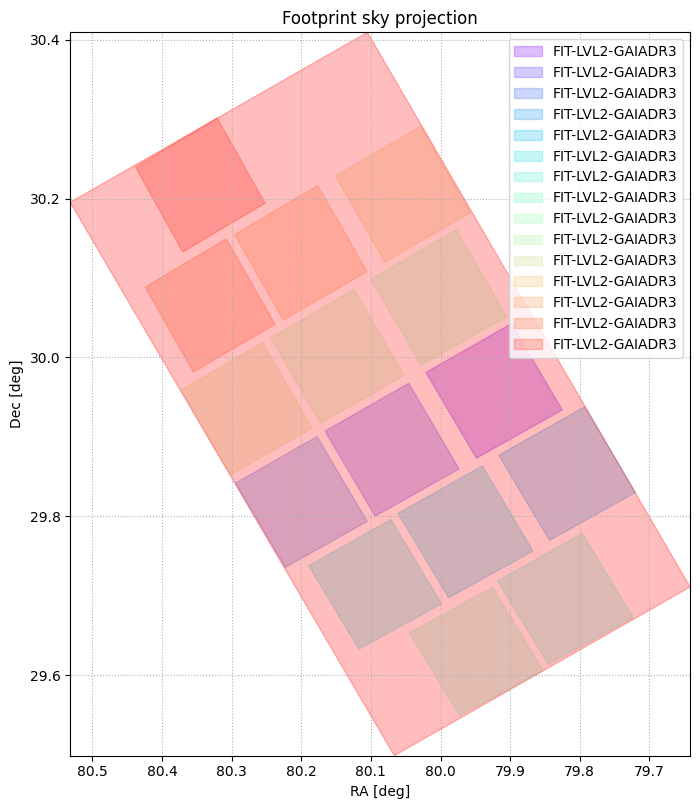

In [37]:
wcs_list = []
wcs_list.extend([x.meta.wcs for x in [*mc, res]])
wcs_single = wfv.plot(wcs_list)